# Experimenting with binning SibSp and Parch

In [122]:
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer

In [123]:
df = pd.read_csv("../data/raw/train.csv").drop('PassengerId', axis=1)
dfX = df.drop(["Survived"], axis=1)
dfy = df.Survived


In [124]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [125]:
df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [126]:
def FE_SibSp(arr: np.array):
#     arr = arr.copy()
    arr[arr>1] = 2
    if len(arr.shape) == 1:
        arr = arr.reshape(-1, 1)
    return arr

In [127]:
df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [128]:
def FE_Parch(arr: np.array):
    arr = arr.copy()
    arr[arr>1] = 2
    if len(arr.shape) == 1:
        arr = arr.reshape(-1, 1)
    return arr

In [129]:
from src.preprocessing import NaNDropper
from sklearn.pipeline import Pipeline

In [130]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = prepare_data.fit_transform(dfX, dfy)

In [131]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [132]:
imp_scale = Pipeline([
    ('imp', SimpleImputer()),
    ('scaler', StandardScaler())
], 'passthrough')

bin_enc_1 = Pipeline([
    ('binner', FunctionTransformer(FE_SibSp)),
    ('enc', OneHotEncoder(drop='first'))
])

bin_enc_2 = Pipeline([
    ('binner', FunctionTransformer(FE_Parch)),
    ('enc', OneHotEncoder(drop='first'))
])


preprocess_data = ColumnTransformer([
        ('clmn_drpr', 'drop', ['Name', 'Ticket', 'Cabin']),
        ('enc', OneHotEncoder(drop='first'), ['Sex', 'Embarked']),
        ('imp_scaler', imp_scale, ['Age', 'Fare']),
        ('bin_enc_1', bin_enc_1, ['SibSp']),
        ('bin_enc_2', bin_enc_2, ['Parch'])
    ], 'passthrough')

In [159]:
preprocess_data.fit_transform(dfX_pre, dfy_pre).shape

(889, 10)

In [160]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [161]:
pipe = Pipeline([
    ('preprocess', preprocess_data),
    ('clf', RandomForestClassifier(random_state=1))
])

In [162]:
pipe.fit(dfX_pre, dfy_pre);

In [163]:
pipe.score(dfX_pre, dfy_pre)

0.9820022497187851

In [164]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cross_val_score(pipe, dfX_pre, dfy_pre, cv=skf).mean()

0.7998032120865867

In [165]:
from src.utils import print_params

In [166]:
print_params(pipe)

['memory',
 'steps',
 'verbose',
 'preprocess',
 'clf',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__clmn_drpr',
 'preprocess__enc',
 'preprocess__imp_scaler',
 'preprocess__bin_enc_1',
 'preprocess__bin_enc_2',
 'preprocess__enc__categories',
 'preprocess__enc__drop',
 'preprocess__enc__dtype',
 'preprocess__enc__handle_unknown',
 'preprocess__enc__sparse',
 'preprocess__imp_scaler__memory',
 'preprocess__imp_scaler__steps',
 'preprocess__imp_scaler__verbose',
 'preprocess__imp_scaler__imp',
 'preprocess__imp_scaler__scaler',
 'preprocess__imp_scaler__imp__add_indicator',
 'preprocess__imp_scaler__imp__copy',
 'preprocess__imp_scaler__imp__fill_value',
 'preprocess__imp_scaler__imp__missing_values',
 'preprocess__imp_scaler__imp__strategy',
 'preprocess__imp_scaler__imp__verbose',
 'preprocess__imp_scaler__scaler__copy',
 'preprocess__imp_scaler__

## Try various models with the default hyperparameters


In [167]:
from sklearn.model_selection import GridSearchCV

In [168]:
models = [
    RidgeClassifier(),
    LogisticRegression(solver="liblinear"),  # liblinear is better for small datasets
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(),
    RandomForestClassifier(random_state=1),
    BaggingClassifier(random_state=1)
]

param_grid = {'clf': models}

In [169]:
grid = GridSearchCV(pipe, param_grid, cv=skf)
grid.fit(dfX_pre, dfy_pre);

In [170]:
print(grid.best_params_)
print(grid.best_score_)

{'clf': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)}
0.8155398971624453


So I can get \~82% accuracy by no hyperparameter tuning in the pipeline by using `SVC`. Nice! :D <br/>

<font color='red'>DOUBT</font>: Do I need to separately see the OOB accuracy for `RandomForestClassifier`?

In [171]:
import seaborn as sns

In [172]:
res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.023921,0.000621,0.008962,0.000172,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf': SVC(C=1.0, break_ties=False, cache_siz...",0.853933,0.831461,0.775281,0.786517,0.830508,0.815540,0.029714,1
1,0.017446,0.000369,0.008669,0.000279,"LogisticRegression(C=1.0, class_weight=None, d...","{'clf': LogisticRegression(C=1.0, class_weight...",0.842697,0.814607,0.747191,0.797753,0.847458,0.809941,0.036300,2
6,0.029444,0.000715,0.008238,0.000243,"BaggingClassifier(base_estimator=None, bootstr...","{'clf': BaggingClassifier(base_estimator=None,...",0.792135,0.859551,0.764045,0.803371,0.830508,0.809922,0.032713,3
0,0.024410,0.010320,0.011802,0.005636,"RidgeClassifier(alpha=1.0, class_weight=None, ...","{'clf': RidgeClassifier(alpha=1.0, class_weigh...",0.848315,0.803371,0.741573,0.803371,0.836158,0.806557,0.037049,4
2,0.014541,0.001261,0.013692,0.001640,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'clf': KNeighborsClassifier(algorithm='auto',...",0.820225,0.825843,0.758427,0.803371,0.813559,0.804285,0.024119,5


In [173]:
from src.plotting import plot_grid_results

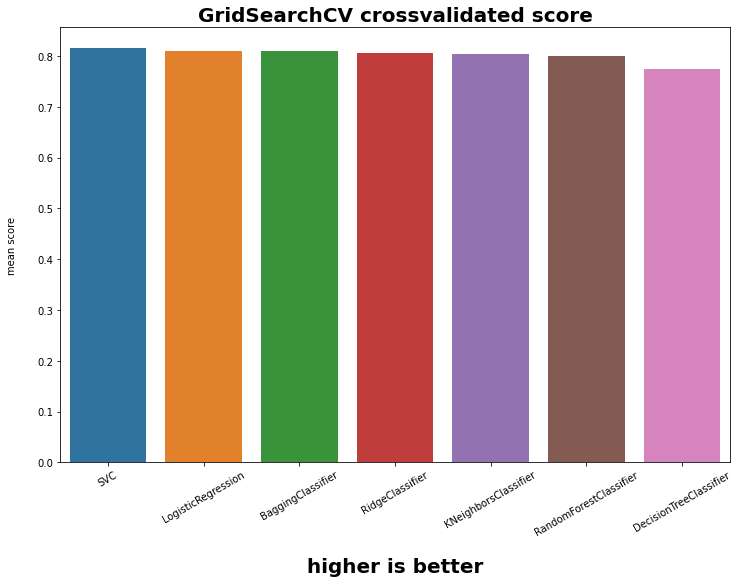

In [174]:
plot_grid_results(grid, 'clf', 'score');

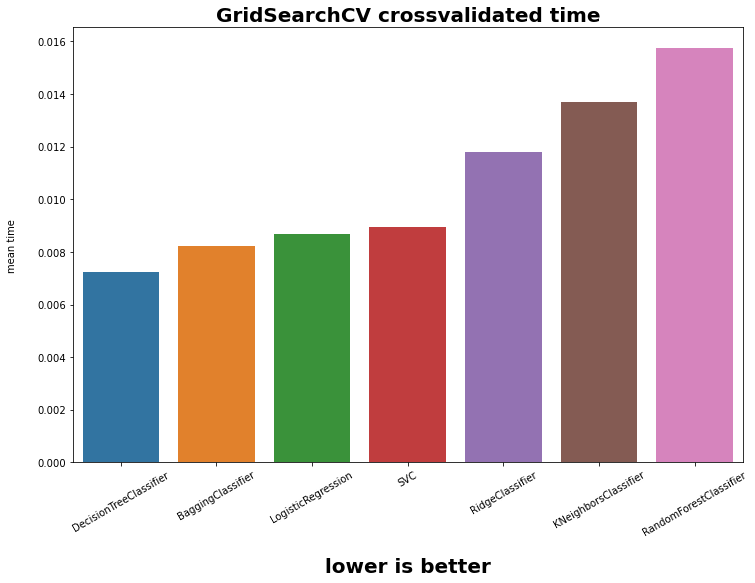

In [175]:
plot_grid_results(grid, 'clf', 'time');